# Spitfire Example: chemical explosive mode analysis of two-temperature ignition pathways

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from spitfire.chemistry.mechanism import ChemicalMechanismSpec
from spitfire.chemistry.flamelet import Flamelet
from spitfire.chemistry.tabulation import Dimension, Library

In [2]:
mechanism = ChemicalMechanismSpec(cantera_xml='dme-bhagatwala.xml', group_name='dme-bhagatwala')

In [19]:
pressure = 101325.

air = mechanism.stream(stp_air=True)
air.TP = 1200., pressure
fuel = mechanism.stream('TPX', (300., pressure, 'CH3OCH3:1,CH4:1'))

npts_mixfrac = 128
nchi = 128
chist_vec = np.logspace(-4., 4., nchi)

flamelet_specs = {'mech_spec': mechanism,
                  'pressure': pressure,
                  'initial_condition': 'unreacted',
                  'oxy_stream': air,
                  'fuel_stream': fuel,
                  'grid_points': npts_mixfrac,
                  'grid_type': 'clustered',
                  'include_enthalpy_flux': True,
                  'include_variable_cp': True}

quantities = ['temperature', 'mass fraction C2H2']
include_explosive_mode_analysis = True

def generate_ign_ext_branches(flamelet_specs, quantities, include_cema):
    flamelet = Flamelet(**flamelet_specs)

    zdim = Dimension('mixture_fraction', flamelet.mixfrac_grid)
    xdim = Dimension('dissipation_rate_stoich', chist_vec)

    l_ext = Library(xdim, zdim)
    l_ign = Library(xdim, zdim)

    for q in quantities:
        l_ign[q] = l_ign.get_empty_dataset()
        l_ext[q] = l_ext.get_empty_dataset()

    if include_cema:
        cema_dict = dict()
        flamelet.insitu_process_cema(explosion_indices=True, participation_indices=False, secondary_mode=True)
        for q in flamelet._enabled_insitu_processors:
            cema_dict[q] = list()
            l_ign[q] = l_ign.get_empty_dataset()
            l_ext[q] = l_ext.get_empty_dataset()

    for ichi, chist in enumerate(chist_vec[::-1]):
        flamelet_specs.update({'stoich_dissipation_rate': chist})
        flamelet_specs.update({'initial_condition': 'unreacted' if ichi == 0 else f.final_interior_state})
        f = Flamelet(**flamelet_specs)
        f.steady_solve_psitc(verbose=True, log_rate=800, max_iterations=8000, tolerance=1.e-6)
        if include_cema:
            for q in flamelet._enabled_insitu_processors:
                cema_dict[q] = list()
            f.insitu_process_cema(explosion_indices=True, participation_indices=False, secondary_mode=True)
            f._do_insitu_processing(None, f.final_state, cema_dict)
            for q in flamelet._enabled_insitu_processors:
                l_ign[q][nchi - 1 - ichi, :] = cema_dict[q][0]
        data_dict = f.process_quantities_on_state(f.final_state, quantities)
        for quantity in quantities:
            l_ign[quantity][nchi - 1 - ichi, :] = data_dict[quantity].ravel()
        print(f'{chist:.1e}', end=', ')

    for ichi, chist in enumerate(chist_vec):
        flamelet_specs.update({'stoich_dissipation_rate': chist})
        flamelet_specs.update({'initial_condition': f.final_interior_state})
        f = Flamelet(**flamelet_specs)
        f.steady_solve_psitc(verbose=True, log_rate=800, max_iterations=8000, tolerance=1.e-6)
        if include_cema:
            for q in flamelet._enabled_insitu_processors:
                cema_dict[q] = list()
            f.insitu_process_cema(explosion_indices=True, participation_indices=False, secondary_mode=True)
            f._do_insitu_processing(None, f.final_state, cema_dict)
            for q in flamelet._enabled_insitu_processors:
                l_ext[q][nchi - 1 - ichi, :] = cema_dict[q][0]
        data_dict = f.process_quantities_on_state(f.final_state, quantities)
        for quantity in quantities:
            l_ext[quantity][ichi, :] = data_dict[quantity].ravel()
        print(f'{chist:.1e}', end=', ')
    
    return dict({'ext': l_ext, 'ign': l_ign})

In [21]:
libraries = dict()
libraries['dme 1200 K'] = generate_ign_ext_branches(flamelet_specs, quantities, True)

air2 = mechanism.copy_stream(air)
air2.TP = 1000., pressure
fs2 = dict(flamelet_specs)
fs2.update({'oxy_stream': air2})
libraries['dme 1000 K'] = generate_ign_ext_branches(fs2, quantities, True)

air2 = mechanism.copy_stream(air)
air2.TP = 800., pressure
fs2 = dict(flamelet_specs)
fs2.update({'oxy_stream': air2})
libraries['dme 800 K'] = generate_ign_ext_branches(fs2, quantities, True)

1.0e+04, 8.6e+03, 7.5e+03, 6.5e+03, 5.6e+03, 4.8e+03, 4.2e+03, 3.6e+03, 3.1e+03, 2.7e+03, 2.3e+03, 2.0e+03, 1.8e+03, 1.5e+03, 1.3e+03, 1.1e+03, 9.8e+02, 8.5e+02, 7.3e+02, 6.4e+02, 5.5e+02, 4.8e+02, 4.1e+02, 3.6e+02, 3.1e+02, 2.7e+02, 2.3e+02, 2.0e+02, 1.7e+02, 1.5e+02, 1.3e+02, 1.1e+02, 9.6e+01, 8.3e+01, 7.2e+01, 6.2e+01, 5.4e+01, 4.7e+01, 4.0e+01, 3.5e+01, 3.0e+01, 2.6e+01, 2.3e+01, 2.0e+01, 1.7e+01, 1.5e+01, 1.3e+01, 1.1e+01, 9.5e+00, 8.2e+00, 7.1e+00, 6.1e+00, 5.3e+00, 4.6e+00, 4.0e+00, 3.4e+00, 3.0e+00, 2.6e+00, 2.2e+00, 1.9e+00, 1.7e+00, 1.4e+00, 1.2e+00, 1.1e+00, 9.3e-01, 8.0e-01, 7.0e-01, 6.0e-01, 5.2e-01, 4.5e-01, 3.9e-01, 3.4e-01, 2.9e-01, 2.5e-01, 2.2e-01, 1.9e-01, 1.6e-01, 1.4e-01, 1.2e-01, 1.1e-01, 9.1e-02, 7.9e-02, 6.8e-02, 5.9e-02, 5.1e-02, 4.4e-02, 3.8e-02, 3.3e-02, 2.9e-02, 2.5e-02, 2.1e-02, 1.9e-02, 1.6e-02, 1.4e-02, 1.2e-02, 1.0e-02, 9.0e-03, 7.8e-03, 6.7e-03, 5.8e-03, 5.0e-03, 4.3e-03, 3.8e-03, 3.2e-03, 2.8e-03, 2.4e-03, 2.1e-03, 1.8e-03, 1.6e-03, 1.4e-03, 1.2e-03, 1

  line search reducing step size to 0.500
  line search reducing step size to 0.500
  line search reducing step size to 0.250
  line search reducing step size to 0.500
  line search reducing step size to 0.250
  line search reducing step size to 0.500
  line search reducing step size to 0.250
  line search reducing step size to 0.500
  line search reducing step size to 0.500
1.7e+01,   line search reducing step size to 0.500
  line search reducing step size to 0.250
  line search reducing step size to 0.500
  line search reducing step size to 0.250
  line search reducing step size to 0.500
  line search reducing step size to 0.250
  line search reducing step size to 0.500
  line search reducing step size to 0.250
  line search reducing step size to 0.500
  line search reducing step size to 0.250
  line search reducing step size to 0.500
  line search reducing step size to 0.500
  line search reducing step size to 0.500
  line search reducing step size to 0.500
  line search reducing st

In [22]:
def make_ignext_plot(library_dict, var_name, levels=None, norm=None):
    fig, axarray = plt.subplots(2, 1, sharex=True)
    axarray[0].set_title(var_name)
    axarray[0].contourf(library_dict['ign'].mixture_fraction_grid, library_dict['ign'].dissipation_rate_stoich_grid, library_dict['ign'][var_name], levels=levels, norm=norm)
    axarray[0].set_yscale('log')
    axarray[0].set_ylabel('$\\chi_{st}$ ignition')
    axarray[1].contourf(library_dict['ext'].mixture_fraction_grid, library_dict['ext'].dissipation_rate_stoich_grid, library_dict['ext'][var_name], levels=levels, norm=norm)
    axarray[1].set_yscale('log')
    axarray[1].set_xlabel('mixture fraction')
    axarray[1].set_ylabel('$\\chi_{st}$ extinction')
    axarray[1].set_ylim([np.max(chist_vec), np.min(chist_vec)])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.show()

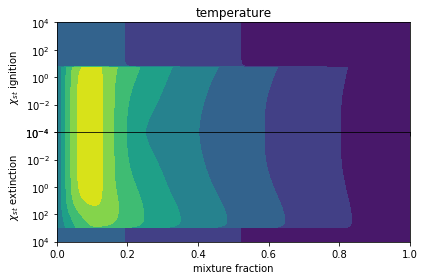

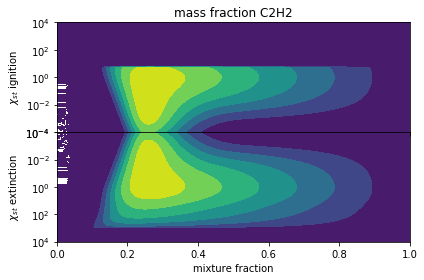

/projects/spitfire_dev/anaconda3/envs/spitfire_master_python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  after removing the cwd from sys.path.
/projects/spitfire_dev/anaconda3/envs/spitfire_master_python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


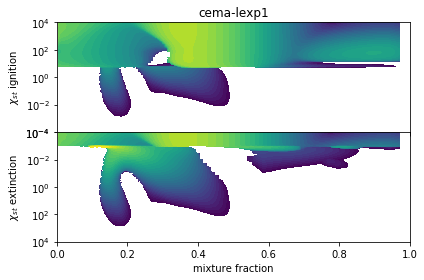

In [23]:
ld = libraries['dme 1200 K']

make_ignext_plot(ld, 'temperature')
make_ignext_plot(ld, 'mass fraction C2H2')
make_ignext_plot(ld, 'cema-lexp1', np.logspace(-2, 4, 40), LogNorm(vmin=1.e-2, vmax=1e4))

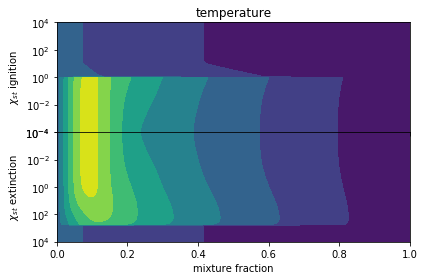

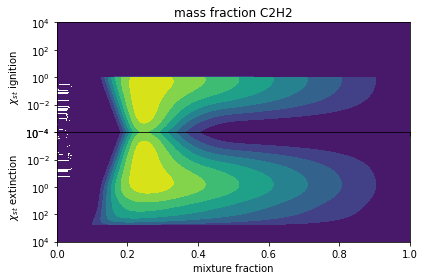

/projects/spitfire_dev/anaconda3/envs/spitfire_master_python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  after removing the cwd from sys.path.
/projects/spitfire_dev/anaconda3/envs/spitfire_master_python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


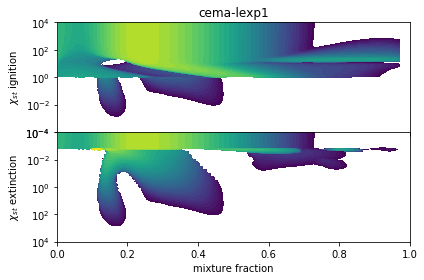

In [25]:
ld = libraries['dme 1000 K']

make_ignext_plot(ld, 'temperature')
make_ignext_plot(ld, 'mass fraction C2H2')
make_ignext_plot(ld, 'cema-lexp1', np.logspace(-2, 4, 40), LogNorm(vmin=1.e-2, vmax=1e4))

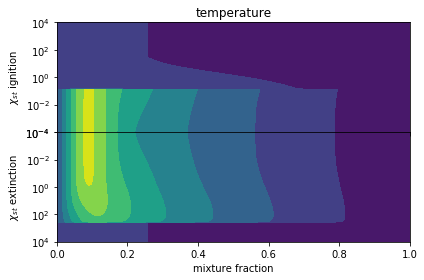

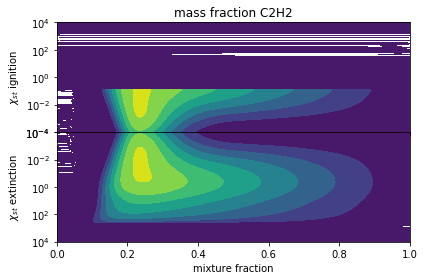

/projects/spitfire_dev/anaconda3/envs/spitfire_master_python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  after removing the cwd from sys.path.
/projects/spitfire_dev/anaconda3/envs/spitfire_master_python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


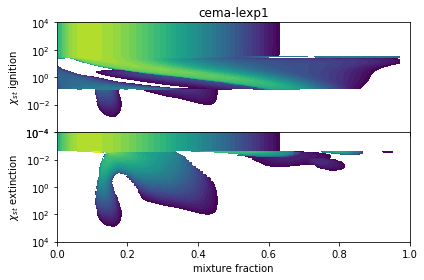

In [26]:
ld = libraries['dme 800 K']

make_ignext_plot(ld, 'temperature')
make_ignext_plot(ld, 'mass fraction C2H2')
make_ignext_plot(ld, 'cema-lexp1', np.logspace(-2, 4, 40), LogNorm(vmin=1.e-2, vmax=1e4))